In [1]:
import autograd
from autograd.builtins import tuple
import autograd.numpy as np
import pandas as pd
from typing import List

#Import ode solver and rename as BlackBox for consistency with blog
from scipy.integrate import odeint as BlackBox
import matplotlib.pyplot as plt

In [2]:
def get_Gprod0(params: List[float]) -> float:
    """
    Return the value of Gprod0 given a list of input params
    """
    return params[6]*params[14]*params[15]+params[5]*params[14]

In [3]:
def time_delay(params: List[float], t: float, J: List[float]) -> float:
    if t < params[3]:
        return 0
    else:
        return J[int(np.round(t - params[3]))]

In [4]:
def Gprod(params: List[float], g: float) -> float:
    """
    Calculate the value of G_prod at some point glucose level = g.
    """
    return params[8] / (params[8] / get_Gprod0(params) + (g - params[14]))

In [5]:
def f(y, t, params):
    '''
    Define the ODE
    '''
    s, j, l, g, i = y

    dsdt = -params[0] * s
    djdt = params[0] * s - params[1] * j - params[2] * j
    J[round(t)] = j
    dldt = params[2] * time_delay(params, t, J) - params[4] * l
    dgdt = -(params[5] + params[6] * i) * g + Gprod(params, g) + params[7] * (params[1] * j + params[4] * l)
    num = params[12] ** params[11] + 1
    G_tilda = g + params[9] * (params[1] * j + params[4] * l)
    denom = (params[12] ** params[11]) * (params[14] / G_tilda) ** params[11] + 1
    didt = params[10] * params[15] * (num / denom - i / params[15])
    return np.array([dsdt, djdt, dldt, dgdt, didt])

In [6]:
# Jabobian matrix wrt y
Jacob = autograd.jacobian(f, argnum=0) # Here 0 means position 0 in function f(y, t, theta) -- taking Jacobian wrt f[0] = y
# Gradient wrt theta
grad_f_theta = autograd.jacobian(f, argnum=2)

In [7]:
def ODESYS(Y, t, params):
    
    # ODE
    dy_dt = f(Y[0:5], t, params)
    # Sensitivities
#     print(Y.shape)
#     print(grad_f_theta(Y[:5], t, params).shape)
    grad_y_theta = Jacob(Y[:5], t, params)@(Y[5::].reshape(5, 17)) + grad_f_theta(Y[:5], t, params)
    # Haven't calculated sensitivities yet
    grad_y_theta = grad_y_theta.flatten()
    
    return np.concatenate([dy_dt, grad_y_theta])

In [8]:
def Cost(y_obs):
    def cost(Y):
        n = y_obs.shape[0]
        err = np.linalg.norm(y_obs-Y, 'fro')
        print(np.sum(err)/n)
        return np.sum(err)/n
    
    return cost

## Real Data to Fit

In [20]:
from datetime import datetime
import pandas as pd
from typing import List, Tuple, Dict, Any, Union
import GIDynamics
import matplotlib.pyplot as plt
from itertools import product
import math
from scipy.integrate import odeint as BlackBox


In [21]:
data = pd.read_csv('2020-07-2021_lunch_peak.csv')
data.head()

# print(type(data.time))
# print(type(data.glucose))

# date_time_obj = datetime. strptime(date_time_str, '%d/%m/%y %H:%M:%S')

# Convert the time str to datetime object
time_list = [datetime.strptime(x, '%Y-%m-%d %H:%M:%S') for x in data.time]

# Replace the time str using the new datetime object in dataframe
data.time = time_list

# Determine the time_scope to examine, default is 120min (in the paper)
time_scope = data.shape[0]  # 173 right now

g_exp = np.array(list(data.glucose))
# print(g_exp)

# print(len(g_exp) == 173)
t = np.linspace(0, len(g_exp), len(g_exp))
g_obs = np.array(g_exp)
# print(type(y_obs))
# print(y_obs.shape)

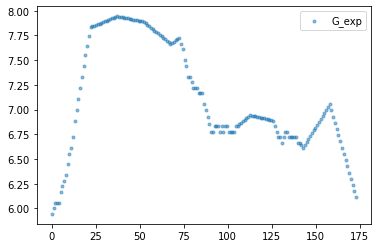

In [22]:
plt.scatter(t, g_obs, marker = '.', alpha = 0.5, label = 'G_exp')

plt.legend()

In [23]:
def nested_matmul(A, B):
    """
    A = (173, 5)
    B = (173, 85)
    Reshape A*B so that it produces the gradient of loss function wrt to params/theta.
    """
    vec_len = A.shape[0]
    num_func = A.shape[1]
    num_grad = int(B.shape[1]/A.shape[1])
    
    l = 0
    grad = np.zeros(num_grad)
    while l < num_grad:
        i = 0
        col = 0
        while i < num_func:
            col += (A[:, i]*B[:, l*5+i]).sum()
            i += 1
        grad[l] = col
        l += 1
    return grad[:16]

In [24]:
theta_iter = np.array([0.1, 0.1, 0.0316, 100, 0.1, 0.01, 10 ** (-6.5), 10 ** (-1.9), \
                       0.0316, 10, 0.01, 5, 100, 10 ** 3, 10 ** 0.8, 10 ** (1.7 - 9)])
Y0 = np.concatenate([np.array([theta_iter[13], 0.0, 0.0, theta_iter[14], theta_iter[15]]), np.array([0.0]*85)])
time = np.linspace(0, len(g_exp)+1, len(g_exp))

print(theta_iter.shape)

(16,)


In [25]:
maxiter = 10
learning_rate = 0.001
for i in range(maxiter):
    J = [0] * (len(g_exp)+2)
    params = np.concatenate([theta_iter, np.array([get_Gprod0(theta_iter)])])
    sol = BlackBox(ODESYS, y0=Y0, t=time, args = tuple([params]))
    print(sol.shape)
    y_obs = sol.copy()
    y_obs[:, 3] = g_obs
    y_obs = y_obs[:, :5]
    Y = sol[:, :5]
    print(y_obs.shape)
    
    cost = Cost(y_obs)
    grad_C = autograd.grad(cost)
    print(grad_C(Y).shape)
    print(sol[:, 5:].shape)
    
    diff = learning_rate*nested_matmul(grad_C(Y), sol[:, 5:])
    print(diff[:16])
    theta_iter -= diff[:16]
#     theta_iter -= learning_rate*(grad_C(Y)*sol[:, 5:]).sum()
    print(theta_iter)
#     if i%10==0:
#         print(theta_iter)

(173, 90)
(173, 5)
Autograd ArrayBox with value 0.1526005235578493
(173, 5)
(173, 85)
Autograd ArrayBox with value 0.1526005235578493
[ 0.00000000e+00  0.00000000e+00  0.00000000e+00 -4.06596363e-02
  0.00000000e+00  0.00000000e+00  0.00000000e+00 -3.09711709e-03
  0.00000000e+00  0.00000000e+00 -1.71653728e-03  2.41560555e-02
 -9.11625282e-12  1.43727864e-03 -7.34210666e-05  4.44493205e-03]
[ 1.00000000e-01  1.00000000e-01  3.16000000e-02  1.00040660e+02
  1.00000000e-01  1.00000000e-02  3.16227766e-07  1.56863712e-02
  3.16000000e-02  1.00000000e+01  1.17165373e-02  4.97584394e+00
  1.00000000e+02  9.99998563e+02  6.30964687e+00 -4.44488193e-03]
(173, 90)
(173, 5)
Autograd ArrayBox with value 1.2327190496935004e+48
(173, 5)
(173, 85)
Autograd ArrayBox with value 1.2327190496935004e+48
[ 0.00000000e+00  0.00000000e+00  0.00000000e+00 -1.57705397e-08
  0.00000000e+00  0.00000000e+00  0.00000000e+00 -4.32566363e-04
  0.00000000e+00  0.00000000e+00 -3.15394321e+49  2.23885496e+49
  8.202

KeyboardInterrupt: 

### MISC

In [27]:
a = np.array([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24])

In [29]:
B = a.reshape(2, 3, 4)

In [30]:
B.flatten()

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24])

In [32]:
B.reshape(4, 3, 2)

array([[[ 1,  2],
        [ 3,  4],
        [ 5,  6]],

       [[ 7,  8],
        [ 9, 10],
        [11, 12]],

       [[13, 14],
        [15, 16],
        [17, 18]],

       [[19, 20],
        [21, 22],
        [23, 24]]])